# Solution for Assignment 1 - Part (A)

# Import of the required Python's libraries

# Question 0

Global initialization of random number generator, so later there is no need to pass any random_state. Moreover, seeding the random number generator is important for reproducibility.

In [2]:
student_id = 12345678 #here you have to indicate your Student ID
np.random.seed(student_id)

# Question 1

**Question**: Load the provided texts and vectorize them to create a data matrix `X` and a label vector `y`. For each text `t`, compute its vector as a weighted average of the sentence embeddings from the first 10 sentences in `t` (or all sentences if shorter). Regarding the weighted average: assign a weight of 3 to the first five sentences and a weight of 1 to the rest. For the sentence embeddings, use the pre-trained language model `all-MiniLM-L6-v2` from the Sentence-Transformers library. Additionally, perform a stratified split of `X,y` into two datasets: `X1,y1` (75% of the samples) and `X2,y2` (25% of the samples). Finally, let the program print the shapes of both `X1,y1` and `X2,y2`.


In [3]:
#function to load texts/labels from files
def read_texts(main_dir, unique_labels):
    texts, labels = [], []
    for label in unique_labels:
        for filename in glob(f'{main_dir}/{label}/*.txt'):
            with open(filename, 'r', encoding='utf-8') as f:
                text = f.read()
            texts.append(text)
            labels.append(label)
    return np.array(texts), np.array(labels)

#this function:
#- takes in input a text to be vectorized, a Spacy pipeline (nlp) and a SBERT model (sbert),
#- returns the numpy vector which represents the text in input.
def vectorize_text(text, nlp, sbert):
    #process the text thru Spacy pipeline
    doc = nlp( str(text) )
    #extract the first 10 sentences (or less if the text is shorter)
    sentences = []
    for i,s in enumerate(doc.sents):
        if i==10: break
        sentences.append(s.text)
    #vectorize each sentence using SBERT
    embeddings = sbert.encode(sentences)
    #calculate the weighted average
    n = embeddings[0].size #it is 384 for the chosen SBERT model
    text_vector = np.zeros(n)
    w_sum = 0.
    for i,v in enumerate(embeddings):
        w = 3. if i<5 else 1. #first five have weight which is the triple of the others
        text_vector += w*v
        w_sum += w
    text_vector /= w_sum
    #return the vector embedding for the given text
    return text_vector
    #done

#main directory and unique labels for the assignment
dataset_dir = 'dataset'
unique_labels = ['cakes', 'chocolate_bars', 'cookies', 'soft_drinks', 'teas']

#load the models for Spacy and the Sentence-Transformer
nlp = spacy.load('en_core_web_md')
sbert = SentenceTransformer('all-MiniLM-L6-v2')

#load all the texts and labels
texts, labels = read_texts(dataset_dir, unique_labels)

#create data-matrix X and target-vector y, corresponding to vectorization of texts and labels
nrows = len(texts)
ncols = 384 #we know this is the size of the vectors returned by the SBERT model all-MiniLM-L6-v2
X = np.empty((nrows,ncols))
y = np.empty(nrows, dtype='int')
for i,(text,label) in enumerate(zip(texts,labels)):
    X[i] = vectorize_text(text, nlp, sbert)
    y[i] = unique_labels.index(label)

#split the dataset X,y into two datasets X1,y1 (75% of the samples) and X2,y2 (25% of the samples) using stratification
#I also pass texts and labels which are parallel to X and y, so they will be splitted consistently
X1,X2,y1,y2,texts1,texts2,labels1,labels2 = train_test_split( X,y,texts,labels, test_size=0.25, stratify=y, shuffle=True )

#print the shape of X1,y1 and X2,y2
print(f'The data matrix X1 has {X1.shape[0]} rows and {X1.shape[1]} columns.')
print(f'The labels vector y1 has {y1.size} entries.')
print(f'The data matrix X2 has {X2.shape[0]} rows and {X2.shape[1]} columns.')
print(f'The labels vector y2 has {y2.size} entries.')

The data matrix X1 has 225 rows and 384 columns.
The labels vector y1 has 225 entries.
The data matrix X2 has 75 rows and 384 columns.
The labels vector y2 has 75 entries.


# Question 2

**Question**: Let the program generate a 2D scatterplot of the entire dataset (`X,y`) using Principal Component Analysis (PCA) and any appropriate preprocessing, if any. Also color each point in the scatterplot according to its class label. Finally, let the program print the percentage of explained variance.

**Comment**: For visualization purposes, PCA has to return two principal components. Moreover, an appropriate preprocessing for PCA is standardization, because it brings all the features on the same scale.

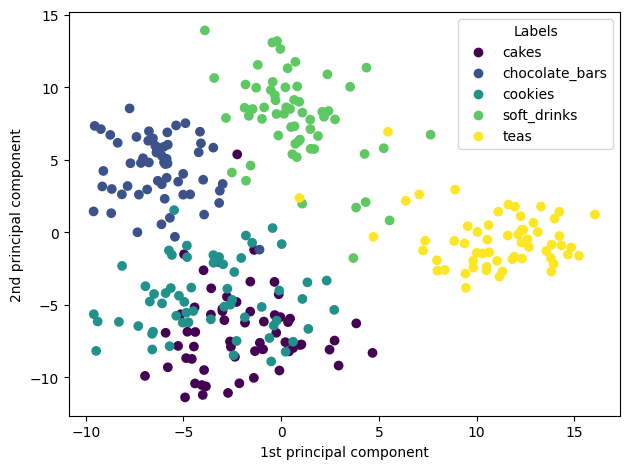

Percentage of explained variance = 0.20


In [4]:
#a suitable preprocessing for PCA is standardization, so let standardize columns of the data matrix X
X_std = StandardScaler().fit_transform(X)

#run PCA with 2 components on the standardized dataset
pca_vis = PCA(2)
X_vis = pca_vis.fit_transform(X_std)

#draw a scatter plot of the principal components
plt.figure()
plt.clf()
scatter = plt.scatter(x = X_vis[:,0],
                      y = X_vis[:,1],
                      c = y)
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.legend(handles = scatter.legend_elements()[0], 
           labels  = unique_labels,
           title   = 'Labels',
           loc     = 'best')
plt.tight_layout()
plt.show()
plt.close()

#print the percentage of variance explained by the two plotted components in total
print(f'Percentage of explained variance = {sum(pca_vis.explained_variance_ratio_):.2f}')

# Question 3

**Question**: Train and test three classification models on the first dataset (`X1,y1`) by considering the following classifiers: Logistic Regression (LR), Random Forest (RF), and K-Nearest Neighbors (KNN). Use the following hyperparameters: RF with 25 estimators and a maximum tree depth of 5, KNN with 9 neighbors, and leave all other hyperparameters at their defaults. For all the classifiers, apply PCA as preprocessing step, retaining 95% of the variance in the training set. Other appropriate preprocessing operations shall be carried out, if any. Execute the experiments by considering the repeated stratified k-fold cross validation with 5 repetitions and 5 folds. Finally, for each classifier, let the program print the mean and the standard deviation of the accuracies obtained.

**Comment**: It is important here to use SKLearn pipelines because in this way we avoid to cheat during the cross-validation. Indeed, not using pipelines and performing vertical preprocessing (e.g., standardization and dimensionality reduction) before the cross-validation implies that the training steps inside any validation round access access information in the test/validation set.

In [5]:
#create 3 pipelines, one for each classifier
#pipelines allows to not use test-set information in the training
#PCA preprocessing is applied to all classifiers and standardization is appropriate before PCA
#KNN works by employing Euclidean distances, so it is appropriate to perform normalization of the rows (but after PCA)
pipeLR  = Pipeline( steps = [ ('std', StandardScaler()),
                              ('pca', PCA(0.95)),
                              ('clf', LogisticRegression())
                            ] )

pipeRF  = Pipeline( steps = [ ('std', StandardScaler()),
                              ('pca', PCA(0.95)),
                              ('clf', RandomForestClassifier(n_estimators=25, max_depth=5))
                            ] )

pipeKNN = Pipeline( steps = [ ('std', StandardScaler()),
                              ('pca', PCA(0.95)),
                              ('nrm', Normalizer()),
                              ('clf', KNeighborsClassifier(n_neighbors=9))
                            ] )

#run classification with cross-validation and print the accuracies
classifiers = {
        'LR':  pipeLR,
        'RF':  pipeRF,
        'KNN': pipeKNN,
    }
print('Accuracies:')
cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5)
best_clf, max_acc = None, 0. #useful for next question
for clf_name,clf in classifiers.items():
    scores = cross_val_score(clf, X1, y1, cv=cv, scoring='accuracy')
    print(f'* {clf_name} = {scores.mean():.2f} +/- {scores.std():.2f}')
    if scores.mean()>max_acc: #useful for next question
        best_clf, max_acc = clf, scores.mean() #useful for next question

Accuracies:
* LR = 0.91 +/- 0.05
* RF = 0.87 +/- 0.05
* KNN = 0.92 +/- 0.04


# Question 4

**Question**: Programmatically select the best classifier among those tested for the previous question. Train it on the first dataset (`X1,y1`) and evaluate its accuracy on the second dataset (`X2,y2`). Then, let the program print the overall accuracy on the second dataset and, for each class label: (i) the per-class accuracy, and (ii) the list of misclassified texts by printing their title (remember: it is the first line in each file) and their true label.

In [6]:
#function to obtain the title of a page (it is the very first line of the texts in the dataset)
def get_title(text):
    return text.split('\n')[0]

#now we can train the best classifier before with the entire 1st dataset
best_clf.fit(X1,y1)

#make inference on X2
y2_pred = best_clf.predict(X2)

#calculate and print the overall accuracy on the second dataset
print(f'The overall accuracy on the 2nd dataset is: {accuracy_score(y2,y2_pred):.2f}')

#for each label (0,1,2,3,4), print the requested informations
print()
for i in [0,1,2,3,4]:
    #calculate accuracy on label i
    acc = 0
    num = 0
    for val_true,val_pred in zip(y2,y2_pred):
        if val_true==i:
            num += 1
            if val_true==val_pred:
                acc += 1
    acc /= num
    #print accuracy on label i
    print(f'Accuracy on label "{unique_labels[i]}": {acc:.2f}')
    #print incorrectly classified instances if accuracy is less than 1
    if acc<1:
        print(f'Incorrectly classified instances for "{unique_labels[i]}" are:')
        for j in range(len(y2)):
            val_true, val_pred = y2[j], y2_pred[j]
            if val_true==i and val_true!=val_pred:
                title, pred_label = get_title(texts2[j]), unique_labels[val_pred]
                print(f'* "{title}" classified as "{pred_label}"')
    #print a new line
    print()

The overall accuracy on the 2nd dataset is: 0.95

Accuracy on label "cakes": 0.93
Incorrectly classified instances for "cakes" are:
* "Basbousa" classified as "cookies"

Accuracy on label "chocolate_bars": 1.00

Accuracy on label "cookies": 0.87
Incorrectly classified instances for "cookies" are:
* "Toll House Inn" classified as "chocolate_bars"
* "Thooththukkudi macaroon" classified as "chocolate_bars"

Accuracy on label "soft_drinks": 0.93
Incorrectly classified instances for "soft_drinks" are:
* "Sarsaparilla (drink)" classified as "teas"

Accuracy on label "teas": 1.00



# Question 5

**Question**: Cluster the texts in the entire dataset (`X`) by running K-Means (KM) with `k` in `{4,5,6}`. Also apply PCA as a preprocessing step, retaining 95% of the explained variance, along with any other appropriate preprocessing, if any. For each of the three clusterings, obtain and print their inertia and silhouette scores.

**Comment**: Standardization is an appropriate preprocessing for PCA, while normalization (of the rows in the data matrix) is appropriate for K-Means because it internally works considering Euclidean distances.

In [7]:
#build up a pipeline formed by standardization and PCA
pipe_red = Pipeline( steps = [ ( 'std', StandardScaler() ),
                               ( 'pca', PCA(0.95) )          ] )

#apply the reduction pipeline
X_red = pipe_red.fit_transform(X)

#print the reduced dimensionality (it is not required by the exercise, but useful)
ncols = X_red.shape[1]
print(f'The reduced dimensionality is {ncols}.')

#normalization is appropriate because KMeans works with Euclidean distances
X_red = Normalizer().fit_transform(X_red)

#execute the three clustering procedures with different number of clusters and print inertia + silhouette
print('Clustering inertia and silhouette:')
kbest, max_silhouette, km_best = -1, -1000., None #-1000 is like "-infinity", it is useful for the next question
for k in [4,5,6]:
    km = KMeans(n_clusters=k)
    km.fit(X_red)
    inertia = km.inertia_
    labels = km.labels_
    silhouette = silhouette_score(X_red, labels)
    print(f'* (k={k}) \t inertia = {inertia:.3f} \t silhouette = {silhouette:.3f}')
    if silhouette>max_silhouette: #the best clustering is the one with the best silhouette score
        kbest, max_silhouette, km_best = k, silhouette, km #useful for next question

The reduced dimensionality is 129.
Clustering inertia and silhouette:
* (k=4) 	 inertia = 235.629 	 silhouette = 0.106
* (k=5) 	 inertia = 226.954 	 silhouette = 0.105
* (k=6) 	 inertia = 221.357 	 silhouette = 0.105


# Question 6

**Question**: Programmatically select the best clustering from the previous question and let the program generate and print an appropriate prompt for a generative LLM (e.g., ChatGPT, Claude, DeepSeek, etc.) that instructs it to create cluster names for all the clusters in the clustering. Then, manually paste the generated prompt into a publicly available LLM of your choice, take a screenshot (of both prompt and response), and upload it to the Jupyter notebook.

**Comment 1**: The best clustering is the one that maximizes the silhouette score, so it was already selected in the code for the previous question.

**Comment 2**: To build a good prompt, I extract the 10 most frequent "useful" lemmas for each cluster. For "useful" lemmas I mean content words, i.e., token which are alphabetical, nouns or proper nouns, and non-stopwords.

In [8]:
#this will be a list of lists:
#- one list per cluster,
#- the list of each cluster contains the first 10 "useful" lemmas in the cluster
lemmas = []

#construct lemmas
for cluster_id in range(kbest):
    #select the texts belonging to the cluster "cluster_id"
    mask = km_best.labels_==cluster_id
    cluster_texts = texts[mask]
    #process the lower-case version of those texts using Spacy
    docs = [ nlp(str(text).lower()) for text in cluster_texts ]
    #extract all lemmas which are alphabetical, nouns or proper nouns, and non-stopwords
    lemmas_of_the_cluster = [ token.lemma_ for doc in docs 
                                               for token in doc 
                                                   if token.is_alpha and token.pos_ in {'NOUN','PROPN'} and not token.is_stop ]
    #select the 10 most common extracted lemmas and append to the lemmas list
    selected_lemmas = []
    for lemma,count in Counter(lemmas_of_the_cluster).most_common(10):
        selected_lemmas.append(lemma)
    lemmas.append(selected_lemmas)

#now I have most frequent useful lemmas for each cluster, so I can build up a prompt for ChatGPT
instruction = f'Assign a meaningful textual label to {kbest} clusters of texts, whose most frequent words are as follows.\n'
input_data  = ''
for cluster_id in range(kbest):
    input_data += f'Cluster {cluster_id} = ' + ' '.join(lemmas[cluster_id]) + '\n'
output_indicator = f'For each cluster print solely the label that must contain as few words as possible (possibly one).\n'
prompt = instruction + input_data + output_indicator
print(prompt)

Assign a meaningful textual label to 4 clusters of texts, whose most frequent words are as follows.
Cluster 0 = cake cookie sugar recipe chocolate butter flour biscuit christmas ingredient
Cluster 1 = bar chocolate milk candy peanut cadbury company product brand kit
Cluster 2 = cola drink coca company product brand pepsi soda beverage gatorade
Cluster 3 = tea leave milk bubble china chinese process factory flavor production
For each cluster print solely the label that must contain as few words as possible (possibly one).



Here is the screenshot of the prompt above executed by ChatGPT.
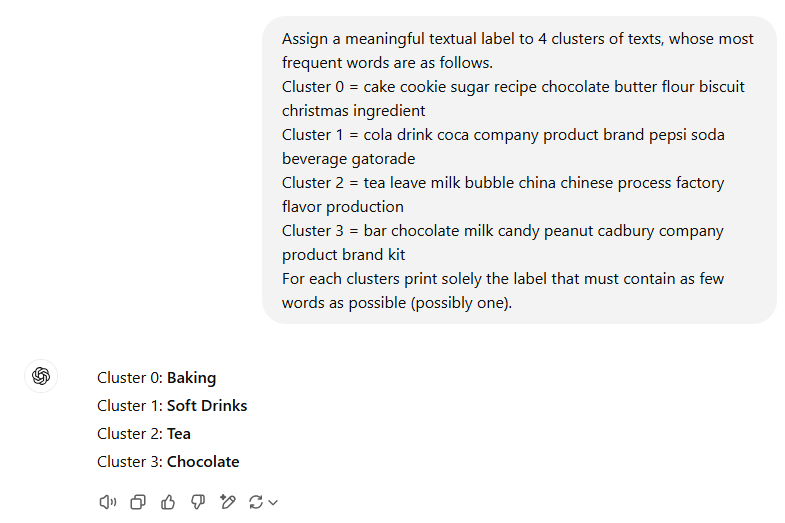

# Question 7

**Question**: Programmatically scrape the content of the “Egg tart” page of Wikipedia (<https://en.wikipedia.org/wiki/Egg_tart>), using the `wikipedia` Python module or any other tool/method of your choice. Assume the following: (i) you run a blog platform, (ii) both the “Egg tart” text and all texts in the entire dataset are articles in a blog, and (iii) the page displaying the “Egg tart” text has space for five article suggestions. Design, describe, and implement a method to populate these suggestion slots. The program should then print the titles of the five recommended articles, ordered by relevance (if applicable).

**Comment**: To suggest the five articles, we vectorize the Egg-tart page and calculate its cosine similarity with respect to all the texts in the entire dataset. Then, we sort the articles in descending order of similarity and we print the first five articles' titles and similarities.

In [9]:
#cosine similarity function between two vectors u and v
#it converts the scipy cosine distance to a similarity
def cos_sim(u,v):
    return 1. - cosine(u,v)

#scrape the Egg-tart page and calculate its vector
page = wiki.page('Egg tart')
q = vectorize_text(page.content, nlp, sbert)

#build up a list of pairs (similarity,title) with an entry for each text in the entire dataset
similarities_titles = [ (cos_sim(q,v), get_title(t)) for v,t in zip(X,texts) ]

#print out the five suggested texts' titles with their similarity to the Egg-tart text
print('The five suggested articles for the "Egg tart" page are:')
for i,(sim,title) in enumerate( sorted(similarities_titles, key=lambda p: p[0], reverse=True)[:5] ):
    print(f'{i+1}. {title} \t sim={sim:.3f}')

The five suggested articles for the "Egg tart" page are:
1. Sesame seed cake 	 sim=0.567
2. Cucumber cake 	 sim=0.519
3. Zuppa inglese 	 sim=0.517
4. Yema cake 	 sim=0.501
5. Teh talua 	 sim=0.500
